# Sales Data Analysis
This data project has been used as a take-home assignment in the recruitment process for the data science positions at 23andMe.

### Assignment
Please answer the questions below based on the data provided:

1. Plot daily sales for all 50 weeks.
2. It looks like there has been a sudden change in daily sales. What date did it occur?
3. Is the change in daily sales at the date you selected statistically significant? If so, what is the p-value?
4. Does the data suggest that the change in daily sales is due to a shift in the proportion of male-vs-female customers? Please use plots to support your answer (a rigorous statistical analysis is not necessary).
5. Assume a given day is divided into four dayparts:
    - night (12:00AM - 6:00AM),
    - morning (6:00AM - 12:00PM),
    - afternoon (12:00PM - 6:00PM),
    - evening (6:00PM - 12:00AM).

    What is the percentage of sales in each daypart over all 50 weeks?

### Data Description
The datasets/ directory contains fifty CSV files (one per week) of timestamped sales data. Each row in a file has two columns:
 - sale_time - The timestamp on which the sale was made e.g. 2012-10-01 01:42:22
 - purchaser_gender - The gender of the person who purchased (male or female)

### Practicalities
Please work on the questions in the displayed order. Make sure that the solution reflects your entire thought process - it is more important how the code is structured rather than the final answers. You are expected to spend no more than 1-2 hours solving this project.

In [1]:
import os
from os import walk
import glob
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [2]:
all_csvs = glob.glob(os.path.join(os.getcwd(), 'Data', r'*.csv'))
if len(all_csvs) > 0:
    df = pd.concat(pd.read_csv(csv) for csv in all_csvs)

df.shape

(204329, 2)

In [3]:
df.head()

,sale_time,purchaser_gender
0,2012-10-01 01:42:22,female
1,2012-10-01 02:24:53,female
2,2012-10-01 02:25:40,female
3,2012-10-01 02:30:42,female
4,2012-10-01 02:51:32,male


In [4]:
df['sale_time'] = pd.to_datetime(df['sale_time'])
df['sale_date'] = df['sale_time'].dt.date
df.head()

,sale_time,purchaser_gender,sale_date
0,2012-10-01 01:42:22,female,2012-10-01
1,2012-10-01 02:24:53,female,2012-10-01
2,2012-10-01 02:25:40,female,2012-10-01
3,2012-10-01 02:30:42,female,2012-10-01
4,2012-10-01 02:51:32,male,2012-10-01


In [5]:
df_daily_sales = df.groupby(['sale_date'])[['purchaser_gender']].count().reset_index()
df_daily_sales.rename(columns={'purchaser_gender':'daily_sale_amount'},inplace=True)
df_daily_sales.head()

,sale_date,daily_sale_amount
0,2012-10-01,514
1,2012-10-02,482
2,2012-10-03,499
3,2012-10-04,546
4,2012-10-05,476


#### 1. Plot daily sales for all 50 weeks.

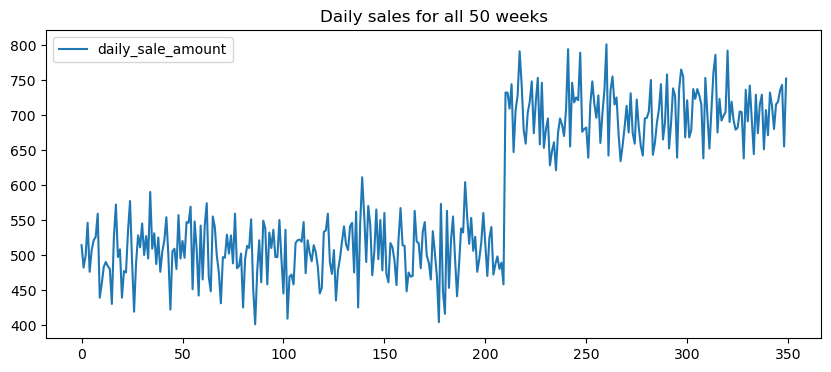

In [6]:
df_daily_sales.plot(figsize=(10,4), title = "Daily sales for all 50 weeks")
plt.show()

#### 2. It looks like there has been a sudden change in daily sales. What date did it occur?

In [7]:
df_daily_sales['sale_diff_DayOverDay'] = df_daily_sales['daily_sale_amount'].diff()
df_daily_sales.head()

,sale_date,daily_sale_amount,sale_diff_DayOverDay
0,2012-10-01,514,NaN
1,2012-10-02,482,-32.0
2,2012-10-03,499,17.0
3,2012-10-04,546,47.0
4,2012-10-05,476,-70.0


In [8]:
df_daily_sales.loc[df_daily_sales['sale_diff_DayOverDay'].idxmax(), 'sale_date']

datetime.date(2013, 4, 29)

In [9]:
df_daily_sales.loc[df_daily_sales.index == df_daily_sales['sale_diff_DayOverDay'].idxmax()]

,sale_date,daily_sale_amount,sale_diff_DayOverDay
210,2013-04-29,732,274.0


#### 3. Is the change in daily sales at the date you selected statistically significant? If so, what is the p-value?

In [10]:
from scipy import stats

df_daily_sales.dropna(inplace=True)
stats.ttest_1samp(df_daily_sales['daily_sale_amount'], 
                  df_daily_sales.loc[df_daily_sales['sale_diff_DayOverDay'].idxmax(), 'daily_sale_amount'])

TtestResult(statistic=-26.273266340051002, pvalue=1.3019593251472396e-84, df=348)

The p-value from the t-test is 1.3019593251472396e-84 which is lower than the assumed threshold of 0.05. It shows that this date is statistically significant.

#### 4. Does the data suggest that the change in daily sales is due to a shift in the proportion of male-vs-female customers? Please use plots to support your answer (a rigorous statistical analysis is not necessary).

In [11]:
df_gender_sales = df.groupby(['sale_date', 'purchaser_gender']).count().reset_index()
df_gender_sales.rename(columns={'sale_time':'sale_amount'},inplace=True)
df_gender_sales.head()

,sale_date,purchaser_gender,sale_amount
0,2012-10-01,female,413
1,2012-10-01,male,101
2,2012-10-02,female,379
3,2012-10-02,male,103
4,2012-10-03,female,386


In [12]:
df_male = df_gender_sales[df_gender_sales['purchaser_gender'] == 'male']
df_female = df_gender_sales[df_gender_sales['purchaser_gender'] == 'female']
df_male.rename(columns={'sale_amount':'male_sale_amount'},inplace=True)
df_female.rename(columns={'sale_amount':'female_sale_amount'},inplace=True)
df_male.drop(['purchaser_gender'], axis=1, inplace=True)
df_female.drop(['purchaser_gender'], axis=1, inplace=True)

In [13]:
print('df_male.shape:',df_male.shape,'\ndf_female.shape:', df_female.shape)

df_male.shape: (350, 2) 
df_female.shape: (350, 2)


In [14]:
df_temp = pd.merge(df_male, df_female, on='sale_date')
df_temp['Male_to_Female_sales_ratio'] = df_temp['male_sale_amount']/df_temp['female_sale_amount']
df_temp['daily_sale_amount'] = df_temp['male_sale_amount'] + df_temp['female_sale_amount']
df_temp.head()

,sale_date,male_sale_amount,female_sale_amount,Male_to_Female_sales_ratio,daily_sale_amount
0,2012-10-01,101,413,0.244552,514
1,2012-10-02,103,379,0.271768,482
2,2012-10-03,113,386,0.292746,499
3,2012-10-04,114,432,0.263889,546
4,2012-10-05,108,368,0.293478,476


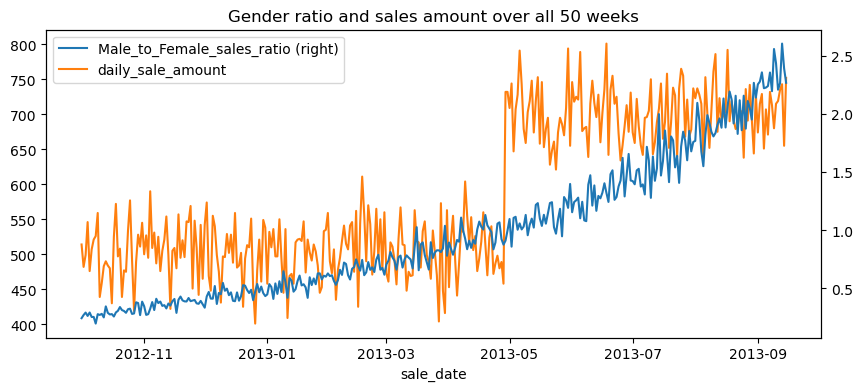

In [15]:
df_temp.drop(['male_sale_amount', 'female_sale_amount'], axis=1, inplace=True)
df_temp.index = df_temp['sale_date']
df_temp.plot(secondary_y = ['Male_to_Female_sales_ratio'],figsize=(10, 4), 
             title= "Gender ratio and sales amount over all 50 weeks")
plt.show()

The increasing trend of the male:female sales ratio does not explain the sudden change in daily sales. 

#### 5. Assume a given day is divided into four dayparts:
    - night (12:00AM - 6:00AM),
    - morning (6:00AM - 12:00PM),
    - afternoon (12:00PM - 6:00PM),
    - evening (6:00PM - 12:00AM).

    What is the percentage of sales in each daypart over all 50 weeks?

In [16]:
df['sale_hour'] = df['sale_time'].dt.hour

def daypart(hour):
    """Assign labels based on sale hour."""
    if hour >= 0 and hour < 6:
        return 'night'
    if hour >= 6 and hour < 12:
        return 'morning'
    if hour >= 12 and hour < 18:
        return 'afternoon'
    if hour >= 18 and hour < 24:
        return 'evening'

df['daypart'] = df['sale_hour'].apply(daypart)
df.drop(['sale_time', 'purchaser_gender', 'sale_hour'], axis=1, inplace=True)
df.head(3)

,sale_date,daypart
0,2012-10-01,night
1,2012-10-01,night
2,2012-10-01,night


In [18]:
df_percent_sales = df.groupby(['daypart']).count().reset_index()
df_percent_sales.rename(columns={'sale_date':'daypart_sale_amount'},inplace=True)
df_percent_sales.head()

,daypart,daypart_sale_amount
0,afternoon,80533
1,evening,42620
2,morning,62870
3,night,18306


In [19]:
df_percent_sales['daypart_percent_sales'] = df_percent_sales['daypart_sale_amount']/df_percent_sales['daypart_sale_amount'].sum()
df_percent_sales.drop(['daypart_sale_amount'], axis=1, inplace=True)
df_percent_sales.head()

,daypart,daypart_percent_sales
0,afternoon,0.394134
1,evening,0.208585
2,morning,0.307690
3,night,0.089591


([<matplotlib.patches.Wedge at 0x1ad00a7ffa0>,
 [Text(-1.0397206459891806, 0.35913921855436665, 'afternoon'),
  Text(-0.010874580055360378, -1.0999462457359541, 'evening'),
  Text(1.099064545885519, 0.045355528631665476, 'morning'),
  Text(0.3055319037818136, 1.0567167339317858, 'night')],
 [Text(-0.5671203523577348, 0.19589411921147268, '39.41%'),
  Text(-0.0059315891211056595, -0.5999706794923385, '20.86%'),
  Text(0.5994897523011922, 0.024739379253635712, '30.77%'),
  Text(0.16665376569917104, 0.576390945780974, '8.96%')])

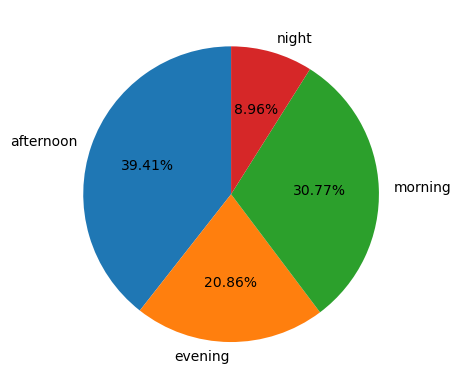

In [20]:
plt.pie(df_percent_sales['daypart_percent_sales'], 
        labels=df_percent_sales['daypart'], autopct='%1.2f%%',
        shadow=False, startangle=90)

We can see that sales is highest in the afternoon, followed by morning, evening and night.